In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import json
import numpy as np
import pandas as pd
from utils import get_cosine_similarity_metrics, get_relevant_ratio, list_s3_prefix, get_file_from_s3
from transformers import AutoTokenizer, AutoModel

surveys = set()
for path in list_s3_prefix("human_resp/"):
    if path.startswith("human_resp/American_Trends_Panel"):
        # Extract the folder name
        folder = path.split("/")[1]
        surveys.add(folder)
surveys = sorted(list(surveys))
question_topic_mapping = np.load(get_file_from_s3('human_resp/topic_mapping.npy'), allow_pickle=True)
question_topic_mapping = question_topic_mapping.item()

survey_topics_mapping = {}
for survey in surveys:
    file_key = f"human_resp/{survey}/info.csv"
    info_df = pd.read_csv(get_file_from_s3(file_key))

    cgs, fgs = [], []
    for idx, row in info_df.iterrows():
        question = row['question']
        ref = f"[{'/'.join([char for char in eval(row['references'])])}]"
        key = ' '.join((question, ref))
        topics = question_topic_mapping[key]
        cgs += topics['cg']
        fgs += topics['fg']

    survey_topics_mapping[survey] = set(fgs)
survey_topics_mapping.keys()

dict_keys(['American_Trends_Panel_W26', 'American_Trends_Panel_W27', 'American_Trends_Panel_W29', 'American_Trends_Panel_W32', 'American_Trends_Panel_W34', 'American_Trends_Panel_W36', 'American_Trends_Panel_W41', 'American_Trends_Panel_W42', 'American_Trends_Panel_W43', 'American_Trends_Panel_W45', 'American_Trends_Panel_W49', 'American_Trends_Panel_W50', 'American_Trends_Panel_W54', 'American_Trends_Panel_W82', 'American_Trends_Panel_W92'])

In [2]:
print(survey_topics_mapping['American_Trends_Panel_W26'])

{'crime/security: terrorism', 'crime/security: justice system', 'crime/security: crime', 'community health', 'healthcare system: healthcare system other', 'personal finance', 'job/career', 'crime/security: guns'}


In [3]:

def get_exp(exp, eval_metrics=False):
    root_dir = f'sm_local/outputs_{exp}'

    # from loggins
    loggings = f"{root_dir}/loggings.json"
    with open(loggings, 'r') as f:
        loggings = json.load(f)

    extraction = loggings['extraction']
    avg_ext_valid = sum([_['valid_ratio'] * _['num_questions_used'] for _ in extraction]) / sum([_['num_questions_used'] for _ in extraction])
    avg_ext_num_persona = sum([_['total_num_personas_extracted'] for _ in extraction]) / len(extraction)
    avg_ext_time = sum([_['extraction_time'] for _ in extraction]) / len(extraction)

    clustering = loggings['clustering']
    avg_cluster_time = sum([_['clustering_time'] for _ in clustering]) / len(clustering)

    summarizing = loggings['summarizing']
    avg_cluster_generated = sum([_['num_of_clusters'] for _ in summarizing]) / len(summarizing)
    avg_sum_persona_generated = sum([_['num_of_personas'] for _ in summarizing]) / len(summarizing)
    avg_sum_valid = sum([_['valid_ratio'] for _ in summarizing]) / len(summarizing)
    avg_sum_time = sum([_['summarizing_time'] for _ in summarizing]) / len(summarizing)

    cleaning = loggings['cleaning']
    avg_clean_valid = sum([_['is_successful'] for _ in cleaning]) / len(cleaning)
    avg_clean_num_persona = sum([_['num_final_personas'] for _ in cleaning]) / len(cleaning)
    avg_clean_time = sum([_['cleaning_time'] for _ in cleaning]) / len(cleaning)

    # eval
    diversity_percentile_metrics = {'low': 0, 'mid': 0, 'high': 0}
    relevant_ratio = 0
    if eval_metrics:
        diversity_percentile_metrics = get_cosine_similarity_metrics(root_dir, tokenizer, model)
        relevant_ratio = get_relevant_ratio(root_dir, survey_topics_mapping)

    res = {
        "avg_ext_num_persona": avg_ext_num_persona,
        "avg_ext_valid": avg_ext_valid,
        "avg_ext_time": avg_ext_time,
        "avg_cluster_generated": avg_cluster_generated,
        "avg_cluster_time": avg_cluster_time,
        "avg_sum_persona_generated": avg_sum_persona_generated,
        "avg_sum_valid": avg_sum_valid,
        "avg_sum_time": avg_sum_time,
        "avg_clean_valid": avg_clean_valid,
        "avg_clean_num_persona": avg_clean_num_persona,
        "avg_clean_time": avg_clean_time,
        "diversity_percentile_metrics_low": diversity_percentile_metrics["low"],
        "diversity_percentile_metrics_mid": diversity_percentile_metrics["mid"],
        "diversity_percentile_metrics_high": diversity_percentile_metrics["high"],
        "relevant_ratio": relevant_ratio
    }
    return res

In [4]:
EVAL_METRICS=True
if EVAL_METRICS:
    tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-2_R')
    model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-2_R', device_map='auto')

for llm in ['haiku', 'sonnet']:
    kmeans = 10
    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    res = get_exp(exp, eval_metrics=EVAL_METRICS)
    print(f"{llm};kmeans;{kmeans};{survey};{extraction_type};{res['avg_ext_valid']};{res['avg_ext_num_persona']};{res['avg_ext_time']};{res['avg_cluster_generated']};{res['avg_cluster_time']};{res['avg_sum_valid']};{res['avg_sum_persona_generated']};{res['avg_sum_time']};{res['avg_clean_valid']};{res['avg_clean_num_persona']};{res['avg_clean_time']};{res['diversity_percentile_metrics_low']};{res['diversity_percentile_metrics_mid']};{res['diversity_percentile_metrics_high']};{res['relevant_ratio']}")
    
    kmeans = 10
    survey = 'single'
    extraction_type = 'description'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    res = get_exp(exp, eval_metrics=EVAL_METRICS)
    print(f"{llm};kmeans;{kmeans};{survey};{extraction_type};{res['avg_ext_valid']};{res['avg_ext_num_persona']};{res['avg_ext_time']};{res['avg_cluster_generated']};{res['avg_cluster_time']};{res['avg_sum_valid']};{res['avg_sum_persona_generated']};{res['avg_sum_time']};{res['avg_clean_valid']};{res['avg_clean_num_persona']};{res['avg_clean_time']};{res['diversity_percentile_metrics_low']};{res['diversity_percentile_metrics_mid']};{res['diversity_percentile_metrics_high']};{res['relevant_ratio']}")
   
    kmeans = 20
    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    res = get_exp(exp, eval_metrics=EVAL_METRICS)
    print(f"{llm};kmeans;{kmeans};{survey};{extraction_type};{res['avg_ext_valid']};{res['avg_ext_num_persona']};{res['avg_ext_time']};{res['avg_cluster_generated']};{res['avg_cluster_time']};{res['avg_sum_valid']};{res['avg_sum_persona_generated']};{res['avg_sum_time']};{res['avg_clean_valid']};{res['avg_clean_num_persona']};{res['avg_clean_time']};{res['diversity_percentile_metrics_low']};{res['diversity_percentile_metrics_mid']};{res['diversity_percentile_metrics_high']};{res['relevant_ratio']}")
   
    gmm = 10
    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_gmm{gmm}_{survey}_{extraction_type}'
    res = get_exp(exp, eval_metrics=EVAL_METRICS)
    print(f"{llm};gmm;{gmm};{survey};{extraction_type};{res['avg_ext_valid']};{res['avg_ext_num_persona']};{res['avg_ext_time']};{res['avg_cluster_generated']};{res['avg_cluster_time']};{res['avg_sum_valid']};{res['avg_sum_persona_generated']};{res['avg_sum_time']};{res['avg_clean_valid']};{res['avg_clean_num_persona']};{res['avg_clean_time']};{res['diversity_percentile_metrics_low']};{res['diversity_percentile_metrics_mid']};{res['diversity_percentile_metrics_high']};{res['relevant_ratio']}")

    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_dbscan_{survey}_{extraction_type}_test'
    res = get_exp(exp, eval_metrics=EVAL_METRICS)
    print(f"{llm};dbscan;-1;{survey};{extraction_type};{res['avg_ext_valid']};{res['avg_ext_num_persona']};{res['avg_ext_time']};{res['avg_cluster_generated']};{res['avg_cluster_time']};{res['avg_sum_valid']};{res['avg_sum_persona_generated']};{res['avg_sum_time']};{res['avg_clean_valid']};{res['avg_clean_num_persona']};{res['avg_clean_time']};{res['diversity_percentile_metrics_low']};{res['diversity_percentile_metrics_mid']};{res['diversity_percentile_metrics_high']};{res['relevant_ratio']}")

    kmeans = 10
    survey = 'same_topic'
    extraction_type = 'example'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    res = get_exp(exp, eval_metrics=EVAL_METRICS)
    print(f"{llm};kmeans;{kmeans};{survey};{extraction_type};{res['avg_ext_valid']};{res['avg_ext_num_persona']};{res['avg_ext_time']};{res['avg_cluster_generated']};{res['avg_cluster_time']};{res['avg_sum_valid']};{res['avg_sum_persona_generated']};{res['avg_sum_time']};{res['avg_clean_valid']};{res['avg_clean_num_persona']};{res['avg_clean_time']};{res['diversity_percentile_metrics_low']};{res['diversity_percentile_metrics_mid']};{res['diversity_percentile_metrics_high']};{res['relevant_ratio']}")



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 13/13 [02:08<00:00,  9.91s/it]


haiku;kmeans;10;single;example;1.0;737.6;383.64743700027464;10.0;81.11092033386231;0.9600000000000002;41.46666666666667;29.767044099171958;0.8666666666666667;33.0;35.05690800348918;0.672620415687561;0.7050308585166931;0.7606400847434998;0.9838383838383838


100%|██████████| 14/14 [01:13<00:00,  5.25s/it]


haiku;kmeans;10;single;description;1.0;290.0;183.5846312046051;10.0;37.716484785079956;1.0;26.2;18.240769831339517;0.9333333333333333;21.4;19.837557538350424;0.6895028054714203;0.7286495089530944;0.7700246155261994;0.9813084112149533


 20%|██        | 2/10 [00:17<01:08,  8.60s/it]


KeyboardInterrupt: 

In [9]:
def get_cleaning_stats(exp):
    root_dir = f'sm_local/outputs_{exp}'

    # from loggins
    loggings = f"{root_dir}/loggings.json"
    with open(loggings, 'r') as f:
        loggings = json.load(f)

    cleaning = loggings['cleaning']
    success = sum([_['is_successful'] for _ in cleaning]) / len(cleaning)

    return len(cleaning), success


for llm in ['haiku', 'sonnet']:
    kmeans = 10
    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    clean_len, success_rate = get_cleaning_stats(exp)
    print(f"{exp}: {clean_len},\n {success_rate}")
    
    kmeans = 10
    survey = 'single'
    extraction_type = 'description'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    clean_len, success_rate = get_cleaning_stats(exp)
    print(f"{exp}: {clean_len},\n {success_rate}")
   
    kmeans = 20
    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    clean_len, success_rate = get_cleaning_stats(exp)
    print(f"{exp}: {clean_len},\n {success_rate}")
   
    gmm = 10
    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_gmm{gmm}_{survey}_{extraction_type}'
    clean_len, success_rate = get_cleaning_stats(exp)
    print(f"{exp}: {clean_len},\n {success_rate}")

    survey = 'single'
    extraction_type = 'example'
    exp = f'{llm}_dbscan_{survey}_{extraction_type}_test'
    clean_len, success_rate = get_cleaning_stats(exp)
    print(f"{exp}: {clean_len},\n {success_rate}")

    kmeans = 10
    survey = 'same_topic'
    extraction_type = 'example'
    exp = f'{llm}_kmeans{kmeans}_{survey}_{extraction_type}'
    clean_len, success_rate = get_cleaning_stats(exp)
    print(f"{exp}: {clean_len},\n {success_rate}")
    

haiku_kmeans10_single_example: 15,
 0.8666666666666667
haiku_kmeans10_single_description: 15,
 0.9333333333333333
haiku_kmeans20_single_example: 15,
 0.6666666666666666
haiku_gmm10_single_example: 15,
 0.8
haiku_dbscan_single_example_test: 15,
 0.9333333333333333
haiku_kmeans10_same_topic_example: 3,
 0.6666666666666666
sonnet_kmeans10_single_example: 15,
 0.8666666666666667
sonnet_kmeans10_single_description: 15,
 0.9333333333333333
sonnet_kmeans20_single_example: 15,
 0.8666666666666667
sonnet_gmm10_single_example: 15,
 0.8666666666666667
sonnet_dbscan_single_example_test: 15,
 1.0
sonnet_kmeans10_same_topic_example: 3,
 1.0


haiku_kmeans10_single_example: 15, 0.8666666666666667
haiku_kmeans10_single_description: 15, 0.9333333333333333
haiku_kmeans20_single_example: 15, 0.6666666666666666
haiku_gmm10_single_example: 15, 0.8
haiku_dbscan_single_example_test: 15, 0.9333333333333333
haiku_kmeans10_same_topic_example: 3, 0.6666666666666666
sonnet_kmeans10_single_example: 15, 0.8666666666666667
sonnet_kmeans10_single_description: 15, 0.9333333333333333
sonnet_kmeans20_single_example: 15, 0.8666666666666667
sonnet_gmm10_single_example: 15, 0.8666666666666667
sonnet_dbscan_single_example_test: 15, 1.0
sonnet_kmeans10_same_topic_example: 3, 1.0


In [4]:
# import pandas as pd

# # get file path under sm_local
# model = 'haiku'
# for kmeans in ['10']:
#     for level in ['high','mid','low']:
#         file_name = f"sm_local/outputs_{model}_kmeans{kmeans}_single_example/cleaned/cleaned_{level}_level_personas_American_Trends_Panel_W26.json"
#         df = pd.read_json(file_name)
#         df.to_csv(f'{model}_kmeans_{kmeans}_single_example_W26_{level}.csv')

In [5]:
# # list all folders in 'pump/sm_local'

# import os

# folders = [_ for _ in os.listdir('sm_local') if _.startswith('outputs') and 'meanshift' not in _]
# folders

In [6]:
# for config in folders:
#     cleaned_dir = f"sm_local/{config}/cleaned"
#     print(cleaned_dir)

#     for filename in os.listdir(cleaned_dir):
#         exp = filename[:-5]
#         os.makedirs(f"sm_local/results/{config}/", exist_ok=True)
#         df = pd.read_json(f"sm_local/{config}/cleaned/{exp}.json")
#         df.to_csv(f"sm_local/results/{config}/{exp}.csv")
#         df.to_json(f"sm_local/results/{config}/{exp}.json", indent=4, orient="records")

# Result Variance

In [29]:
import json
import os
import pandas as pd

res = {}
for filename in os.listdir('opinions_qa/output'):
    # if any(_ not in filename for _ in ['v7', '0804', 'namedesccandvalue']):
    # if any(_ not in filename for _ in ['v7', '0802']):
    if any(_ not in filename for _ in ['v9', 'fix']):
        continue
    # if any(_ in filename for _ in ['fix']):
    #     continue
    exp = filename[:-14]
    if exp not in res:
        res[exp] = []
        
    with open(f"opinions_qa/output/{filename}", 'r') as f:
        data = json.load(f)
    # res[exp] += [f"={sum([_['is_correct'] for _ in data])}/{len(data)}", f"{sum([_['is_correct'] for _ in data])/len(data):.4f}"]
    res[exp] += [f"={sum([_['is_correct'] for _ in data])}/{len(data)}", sum([_['is_correct'] for _ in data])/len(data)]

import numpy as np
df = pd.DataFrame(res)
df = df[sorted(df.columns)]

df = df.transpose()

df['acc_avg'] = df.apply(lambda x: np.mean(x[[1,3,5]]), axis=1)
df['acc_var'] = df.apply(lambda x: np.var(x[[1,3,5]]), axis=1)
df['acc_std'] = df.apply(lambda x: np.std(x[[1,3,5]]), axis=1)
df['acc_avg%'] = df.apply(lambda x: f"{100*x['acc_avg']:.2f}%", axis=1)
df['acc_std%'] = df.apply(lambda x: f"{100*np.std(x[[1,3,5]]):.2f}%", axis=1)

acc_df = df
acc_df

,0,1,2,3,4,5,acc_avg,acc_var,acc_std,acc_avg%,acc_std%
date0805_v9prepmidterm_vanilla_demo_persona_random_American_Trends_Panel_W26,=611/1090,0.56055,=609/1090,0.558716,=610/1090,0.559633,0.559633,5.611200e-07,0.000749,55.96%,0.07%
date0805_v9prepmidterm_vanilla_demo_random_American_Trends_Panel_W26,=619/1090,0.56789,=618/1090,0.566972,=617/1090,0.566055,0.566972,5.611200e-07,0.000749,56.70%,0.07%
date0805_v9prepmidterm_vanilla_no_history_demo_persona_random_American_Trends_Panel_W26,=548/1090,0.502752,=550/1090,0.504587,=550/1090,0.504587,0.503976,7.481600e-07,0.000865,50.40%,0.09%
date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26,=572/1090,0.524771,=570/1090,0.522936,=572/1090,0.524771,0.524159,7.481600e-07,0.000865,52.42%,0.09%
date0805_v9prepmidterm_vanilla_no_history_persona_random_American_Trends_Panel_W26,=529/1090,0.485321,=535/1090,0.490826,=533/1090,0.488991,0.488379,5.237120e-06,0.002288,48.84%,0.23%
date0805_v9prepmidterm_vanilla_persona_random_American_Trends_Panel_W26,=606/1090,0.555963,=609/1090,0.558716,=607/1090,0.556881,0.557187,1.309280e-06,0.001144,55.72%,0.11%
date0805_v9prepmidterm_vanilla_random_American_Trends_Panel_W26,=595/1090,0.545872,=593/1090,0.544037,=593/1090,0.544037,0.544648,7.481600e-07,0.000865,54.46%,0.09%


# Check for CoT errors

In [106]:
import json
import os
import pandas as pd
import re

def extract_cot_prediction(text):
    """
    Extracts text between <prediction> and </prediction> tags.
    
    Args:
    text (str): The input string containing the text with <prediction> tags.
    
    Returns:
    str: The extracted text between the tags. If no tags are found, returns an empty string.
    """
    pattern = re.compile(r'<prediction>(.*?)</prediction>', re.DOTALL)
    match = pattern.search(text)
    if match:
        return match.group(1)
    else:
        return ""

res = {}
for filename in os.listdir('opinions_qa/output'):
    # if any(_ not in filename for _ in ['v7', '0804', 'namedesccandvalue']):
    if any(_ not in filename for _ in ['v8', '0804']):
        continue
    exp = filename[:-5]
    if exp not in res:
        res[exp] = []
        
    with open(f"opinions_qa/output/{filename}", 'r') as f:
        data = json.load(f)
    collection = []
    for entry in data:
        # if entry['is_correct'] == False:
        collection.append((extract_cot_prediction(entry['prediction']), entry['prediction']))

    print(set([_[0] for _ in collection]))
    break

from collections import Counter
Counter([_[0] for _ in collection if _[0]])

{'Essential or Important but not essential', '\nBased on the reasoning above, my prediction is that the participant would choose the option "The world we live in is neither safer nor more dangerous" when asked if they think we live in a safer or more dangerous world compared to 50 years ago.\n', '\nBased on the reasoning above, I predict that the participant\'s response to the survey question "Compared to 50 years ago, do you think" would be "The world we live in is neither safer nor more dangerous". This prediction is based on their moderate level of concern about safety and crime, but lack of strong personal connection to gun ownership or gun culture, which suggests they may not have a strong opinion on whether the world is more or less safe compared to 50 years ago.\n', 'We live in a more dangerous world', 'Should not be done', '\nBased on their responses, I predict that the participant would choose the option "We live in a more dangerous world" when asked if the world is more dange

""
date0804_v8_vanilla_cot_alllevels_allpersonas_namedescvalue_sonnetinfer_American_Trends_Panel_W26


# Get distribution of responses by question

In [61]:
import pandas as pd
from utils import get_file_from_s3

test_q_keys = ['GUNRESPNOKIDSB_W26', 'WORLDDANGER_W26', 'GUNIDENTITY_W26', 'REASONGUNC_W26', 'GUNRESPKIDSC_W26']

survey_df = pd.read_csv(get_file_from_s3(f"human_resp/American_Trends_Panel_W26/info.csv"))
sub_df = survey_df[survey_df['key'].isin(test_q_keys)][['key', 'question', 'references']]
sub_df

,key,question,references
1,WORLDDANGER_W26,"Compared to 50 years ago, do you think","['We live in a safer world', 'We live in a mor..."
17,REASONGUNC_W26,Please indicate whether the following is a maj...,"['Major reason', 'Minor reason', 'Not a reason..."
21,GUNIDENTITY_W26,"How important, if at all, is being a gun owner...","['Very important', 'Somewhat important', 'Not ..."
49,GUNRESPNOKIDSB_W26,Thinking about gun owners who do not have chil...,"['Essential', 'Important but not essential', '..."
57,GUNRESPKIDSC_W26,Thinking about gun owners who have children in...,"['Essential', 'Important but not essential', '..."


In [62]:
q_key_to_q_text = dict(zip(sub_df['key'], sub_df['question']))
q_key_to_q_text

q_texts = [q_key_to_q_text[key] for key in test_q_keys]
q_texts

['Thinking about gun owners who do not have children in their home how important do you think it is for them to: Keep all of their guns unloaded',
 'Compared to 50 years ago, do you think',
 'How important, if at all, is being a gun owner to your overall identity?',
 'Please indicate whether the following is a major reason, a minor reason, or not a reason why you own a gun. For sport shooting, including target shooting and trap and skeet',
 'Thinking about gun owners who have children in their home, how important do you think it is for them to: Take gun safety courses']

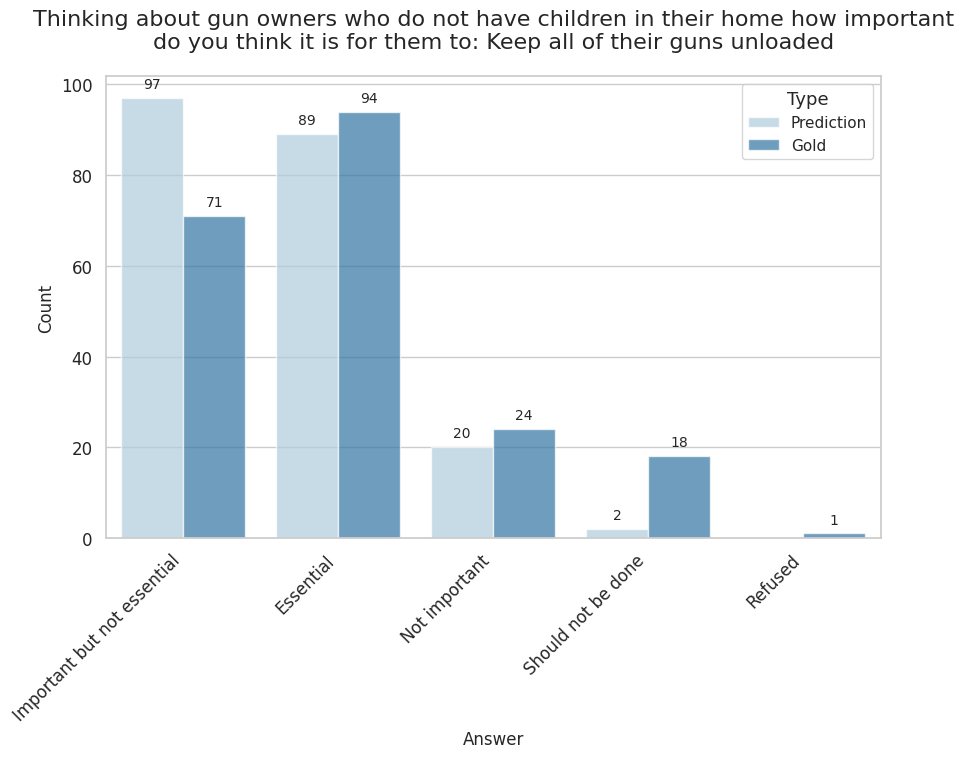

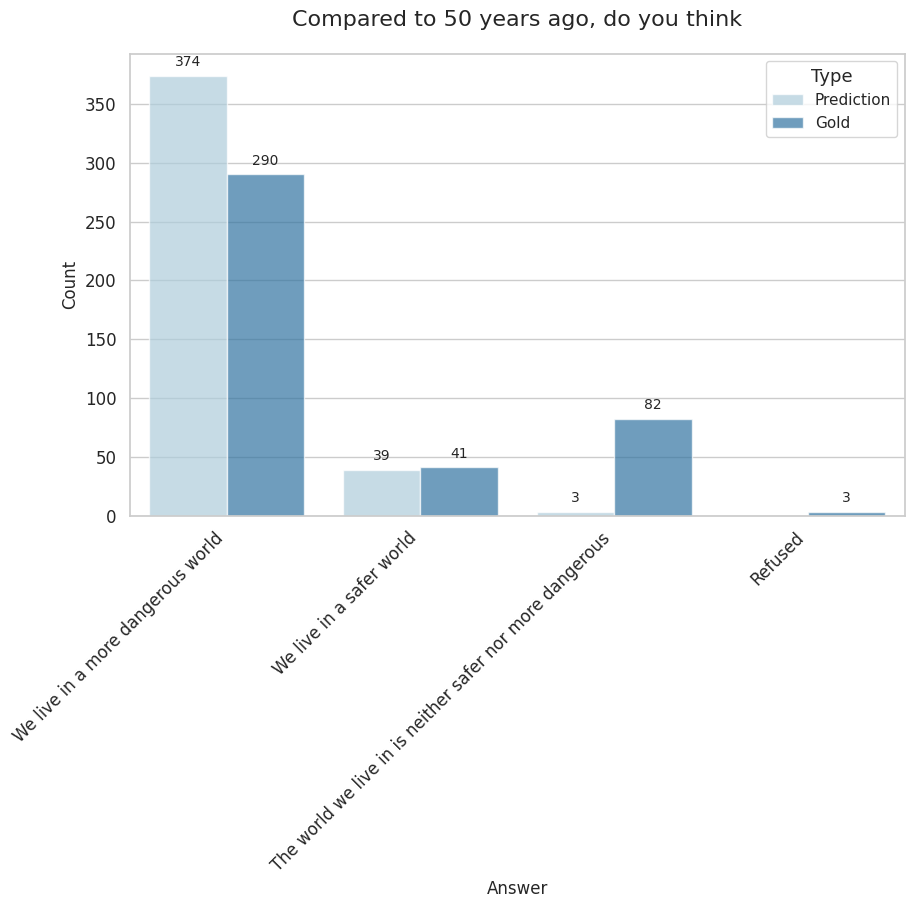

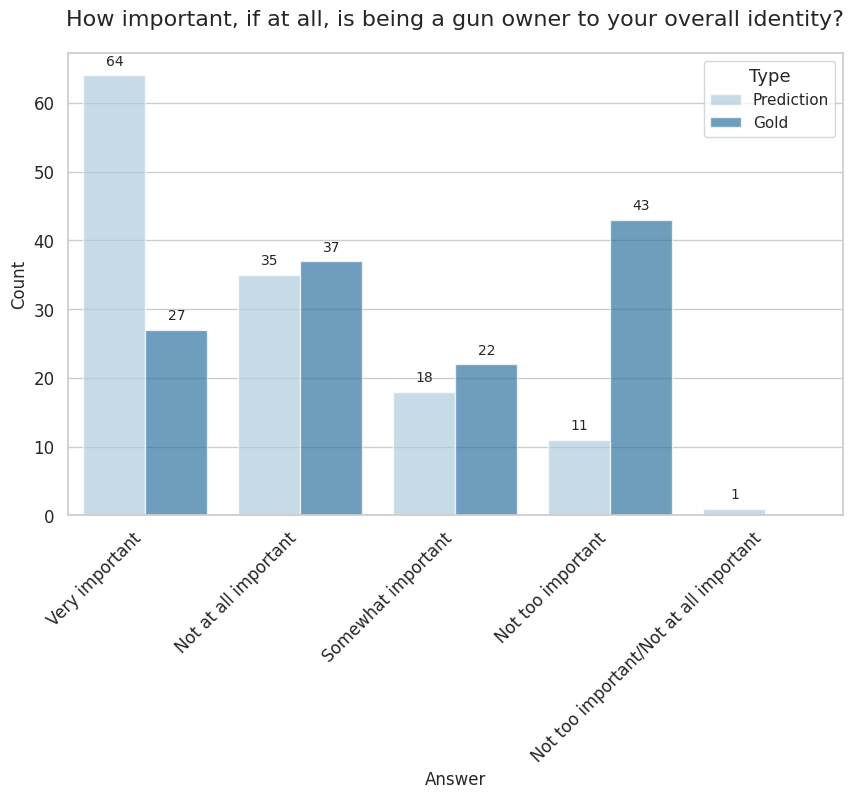

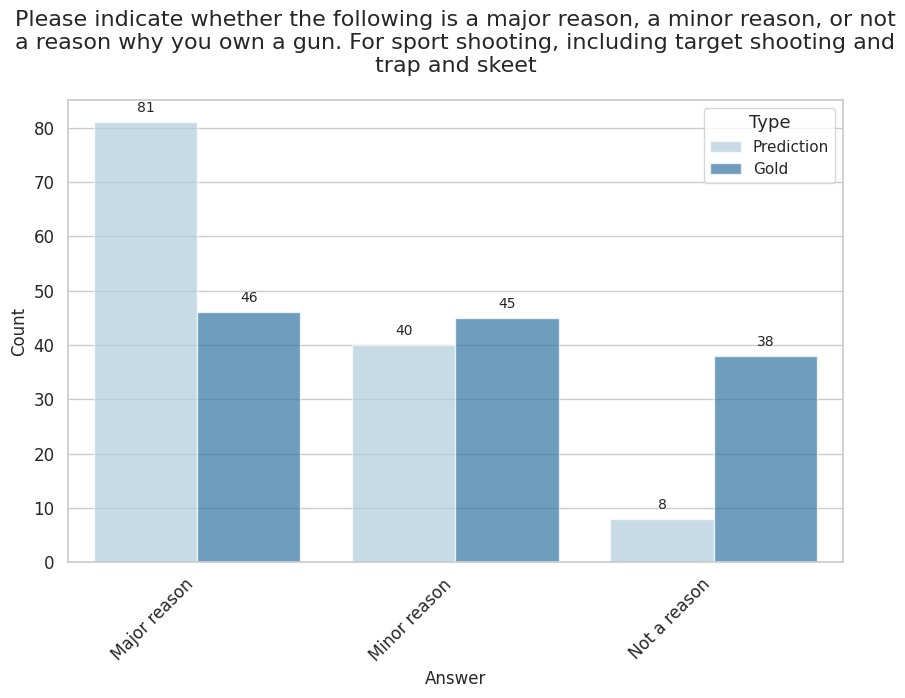

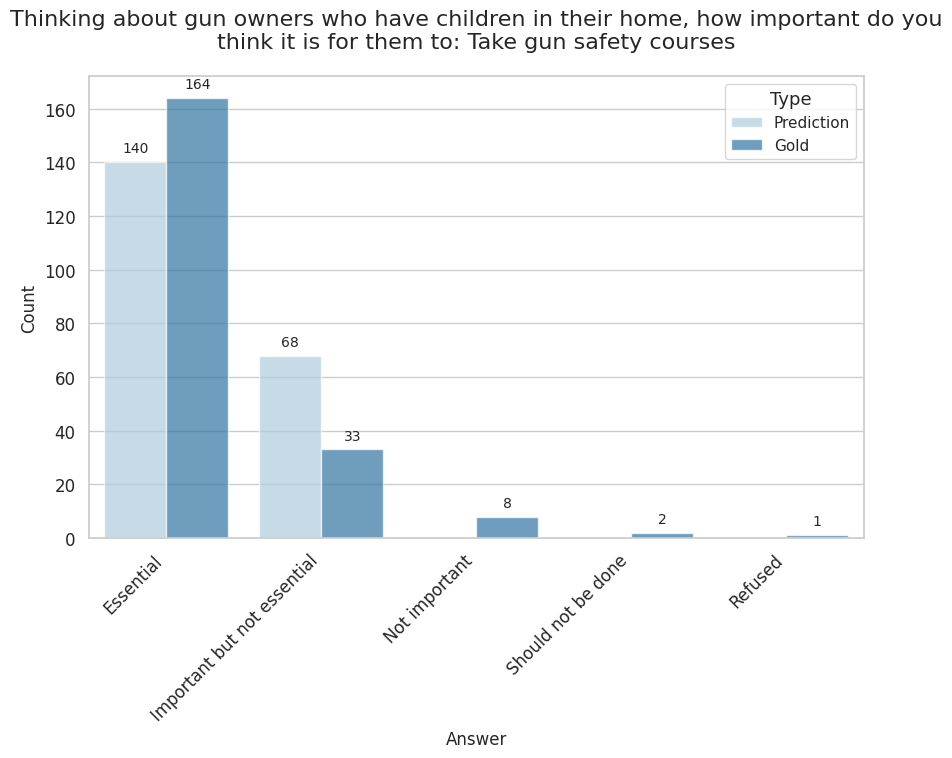

In [75]:
import textwrap
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
res = [{"pred": [], "gold": []} for _ in range(5)]
for filename in os.listdir('opinions_qa/output'):
    # if filename != "date0802_v7_vanilla_demo_persona_alllevels_allpersonas_namedescvalue_sonnetinfer_American_Trends_Panel_W26.json": continue
    # if filename != "date0805_v9prepmidterm_vanilla_persona_random_American_Trends_Panel_W26_run1.json": continue
    if filename != "date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26_run2_fix.json": continue
    with open(f"opinions_qa/output/{filename}", 'r') as f:
        data = json.load(f)

    for entry in data:
        q_idx = entry['q_idx']
        prediction = entry['prediction']
        gold_answer = entry['gold_answer']
        res[q_idx]['pred'].append(prediction)
        res[q_idx]['gold'].append(gold_answer)

# Create dataframes for visualization
dataframes = []
for i in range(5):
    df_pred = pd.Series(res[i]['pred']).value_counts().reset_index()
    df_pred.columns = ['Answer', 'Count']
    df_pred['Type'] = 'Prediction'
    df_pred['Question'] = f'Question {i+1}'
    
    df_gold = pd.Series(res[i]['gold']).value_counts().reset_index()
    df_gold.columns = ['Answer', 'Count']
    df_gold['Type'] = 'Gold'
    df_gold['Question'] = f'Question {i+1}'
    
    dataframes.append(pd.concat([df_pred, df_gold]))

# Plotting
sns.set(style="whitegrid")

# Function to plot the data
def plot_question(df, question_idx):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x="Answer", y="Count", hue="Type", palette=["#a6cee3", "#1f78b4"], alpha=0.7)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points',
                        fontsize=10)
    wrapped_title = "\n".join(textwrap.wrap(q_texts[question_idx], width=80))
    plt.title(wrapped_title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Answer', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Type', title_fontsize='13', fontsize='11')
    plt.show()

# Draw the graphs one by one
for i in range(5):
    plot_question(dataframes[i], i)


# Get 1-WD

In [46]:
import pandas as pd
from utils import get_file_from_s3
test_q_keys = ['GUNRESPNOKIDSB_W26', 'WORLDDANGER_W26', 'GUNIDENTITY_W26', 'REASONGUNC_W26', 'GUNRESPKIDSC_W26']

survey_df = pd.read_csv(get_file_from_s3(f"human_resp/American_Trends_Panel_W26/info.csv"))
sub_df = survey_df[survey_df['key'].isin(test_q_keys)]

sub_df[['key', 'references', 'option_ordinal']]
# sub_df

wd_question_mappings = {row['key']: dict(zip(eval(row['references']), eval(row['option_ordinal']))) for _, row in sub_df.iterrows()}
wd_question_mappings

{'WORLDDANGER_W26': {'We live in a safer world': 1.0,
  'We live in a more dangerous world': 2.0,
  'The world we live in is neither safer nor more dangerous': 1.5},
 'REASONGUNC_W26': {'Major reason': 1.0,
  'Minor reason': 2.0,
  'Not a reason': 3.0},
 'GUNIDENTITY_W26': {'Very important': 1.0,
  'Somewhat important': 2.0,
  'Not too important': 3.0,
  'Not at all important': 4.0},
 'GUNRESPNOKIDSB_W26': {'Essential': 1.0,
  'Important but not essential': 2.0,
  'Not important': 3.0,
  'Should not be done': 4.0},
 'GUNRESPKIDSC_W26': {'Essential': 1.0,
  'Important but not essential': 2.0,
  'Not important': 3.0,
  'Should not be done': 4.0}}

In [69]:
import numpy as np
from scipy.stats import wasserstein_distance


def get_1wd_from_df(df, ref_ord_mapping):
    pred_df = df[df['Type'] == 'Prediction']
    pred_dict = {row['Answer']: row['Count'] for idx, row in pred_df.iterrows() if row['Answer'] != 'Refused'}
    gold_df = df[df['Type'] == 'Gold']
    gold_dict = {row['Answer']: row['Count'] for idx, row in gold_df.iterrows() if row['Answer'] != 'Refused'}

    pred_dict = {k: v for k, v in pred_dict.items() if k in ref_ord_mapping}

    distribution_1 = pred_dict
    distribution_2 = gold_dict

    # print(distribution_1)
    # print(distribution_2)

    # Get the union of keys
    all_keys = sorted(list(set(distribution_1.keys()).union(set(distribution_2.keys()))))

    # Create aligned frequency arrays
    freqs_1 = np.array([distribution_1.get(key, 0) for key in all_keys])
    freqs_2 = np.array([distribution_2.get(key, 0) for key in all_keys])

    # Normalize the frequencies to get probabilities
    probs_1 = freqs_1 / freqs_1.sum()
    probs_2 = freqs_2 / freqs_2.sum()

    # # Compute the cumulative distribution functions
    cdf_1 = np.cumsum(probs_1)
    cdf_2 = np.cumsum(probs_2)

    # Compute the 1-Wasserstein distance

    positions = [ref_ord_mapping[k] for k in all_keys]  # Positions in the sorted key space

    wd_distance = wasserstein_distance(positions, positions, u_weights=probs_1, v_weights=probs_2)
    # wd_distance = wasserstein_distance(positions, positions, u_weights=cdf_1, v_weights=cdf_2)
    # print(positions)
    # print(wd_distance)

    return wd_distance



In [78]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
record = {}
for filename in os.listdir('opinions_qa/output'):
    if any(_ not in filename for _ in ['v9', 'fix']): continue
    print(filename)
    res = [{"pred": [], "gold": []} for _ in range(5)]
    exp = filename[:-14]
    if exp not in record: record[exp] = []

    with open(f"opinions_qa/output/{filename}", 'r') as f:
        data = json.load(f)

    for entry in data:
        q_idx = entry['q_idx']
        prediction = entry['prediction']
        gold_answer = entry['gold_answer']
        res[q_idx]['pred'].append(prediction)
        res[q_idx]['gold'].append(gold_answer)

    # Create dataframes for visualization
    dataframes = []
    for i in range(5):
        df_pred = pd.Series(res[i]['pred']).value_counts().reset_index()
        df_pred.columns = ['Answer', 'Count']
        df_pred['Type'] = 'Prediction'
        df_pred['Question'] = f'Question {i+1}'
        
        df_gold = pd.Series(res[i]['gold']).value_counts().reset_index()
        df_gold.columns = ['Answer', 'Count']
        df_gold['Type'] = 'Gold'
        df_gold['Question'] = f'Question {i+1}'
        
        dataframes.append(pd.concat([df_pred, df_gold]))

    wd = []
    for q_idx, df in enumerate(dataframes):
        key = test_q_keys[q_idx]
        ref_ord_mapping = wd_question_mappings[key]
        wd.append(get_1wd_from_df(df, ref_ord_mapping))
    print(wd)
    record[exp].append(np.mean(wd) * 100)

wd_df = pd.DataFrame(record)
wd_df = wd_df[sorted(wd_df.columns)].transpose()

wd_df['wd_avg'] = wd_df.apply(lambda x: f"{np.mean(x[[0,1,2]]):.2f}", axis=1)
wd_df['wd_std'] = wd_df.apply(lambda x: f"{np.std(x[[0,1,2]]):.2f}", axis=1)
wd_df

date0805_v9prepmidterm_vanilla_persona_random_American_Trends_Panel_W26_run1_fix.json
[0.24440263842437782, 0.010331300055876319, 1.3333333333333335, 0.1162790697674419, 0.1050492382014121]
date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26_run2_fix.json
[0.2006921218877742, 0.10119144626559881, 0.5648619186046512, 0.5038759689922481, 0.17716462281679668]
date0805_v9prepmidterm_vanilla_no_history_persona_random_American_Trends_Panel_W26_run2_fix.json
[0.39613526570048313, 0.10073163065747814, 1.3953488372093026, 0.38759689922480617, 0.07620308435525824]
date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26_run1_fix.json
[0.2028985507246377, 0.10479721549636804, 0.5648619186046512, 0.5038759689922481, 0.17716462281679668]
date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26_run3_fix.json
[0.20549981419546648, 0.10119144626559881, 0.5648619186046512, 0.5038759689922481, 0.17716462281679668]
date0805_v9prepm

,0,1,2,wd_avg,wd_std
date0805_v9prepmidterm_vanilla_demo_persona_random_American_Trends_Panel_W26,37.758797,37.686682,37.579720,37.68,0.07
date0805_v9prepmidterm_vanilla_demo_random_American_Trends_Panel_W26,44.363008,44.290893,44.459162,44.37,0.07
date0805_v9prepmidterm_vanilla_no_history_demo_persona_random_American_Trends_Panel_W26,41.109207,40.702975,40.727014,40.85,0.19
date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26,30.955722,31.071966,31.051875,31.03,0.05
date0805_v9prepmidterm_vanilla_no_history_persona_random_American_Trends_Panel_W26,47.120314,46.821045,47.037391,46.99,0.13
date0805_v9prepmidterm_vanilla_persona_random_American_Trends_Panel_W26,36.187912,36.270835,36.342950,36.27,0.06
date0805_v9prepmidterm_vanilla_random_American_Trends_Panel_W26,47.408804,47.529519,47.529519,47.49,0.06


In [79]:
merged_df = pd.merge(acc_df, wd_df, left_index=True, right_index=True)
merged_df = merged_df[['wd_avg', 'wd_std', 'acc_avg', 'acc_std']]

merged_df.sort_values(by='acc_avg', ascending=False)
merged_df.sort_values(by='wd_avg', ascending=True)


,wd_avg,wd_std,acc_avg,acc_std
date0805_v9prepmidterm_vanilla_no_history_demo_random_American_Trends_Panel_W26,31.03,0.05,0.524159,0.000865
date0805_v9prepmidterm_vanilla_persona_random_American_Trends_Panel_W26,36.27,0.06,0.557187,0.001144
date0805_v9prepmidterm_vanilla_demo_persona_random_American_Trends_Panel_W26,37.68,0.07,0.559633,0.000749
date0805_v9prepmidterm_vanilla_no_history_demo_persona_random_American_Trends_Panel_W26,40.85,0.19,0.503976,0.000865
date0805_v9prepmidterm_vanilla_demo_random_American_Trends_Panel_W26,44.37,0.07,0.566972,0.000749
date0805_v9prepmidterm_vanilla_no_history_persona_random_American_Trends_Panel_W26,46.99,0.13,0.488379,0.002288
date0805_v9prepmidterm_vanilla_random_American_Trends_Panel_W26,47.49,0.06,0.544648,0.000865
